In [1]:
import sys
sys.path.append('../src/')
import itertools
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from models import *
from priors import *

In [3]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    df.train_BA = df.train_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.train_auroc = df.train_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_BA = df.val_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_auroc = df.val_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_BA = df.test_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_auroc = df.test_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

In [4]:
def split_df(df, index):
    X_train = torch.Tensor(df[df.n<=360]['n'].to_numpy())
    y_train = torch.Tensor(np.array(df[df.n<=360]['test_auroc'].to_list())[:,index])
    X_test = torch.Tensor(df[df.n>360]['n'].to_numpy())
    y_test = torch.Tensor(np.array(df[df.n>360]['test_auroc'].to_list())[:,index])
    return X_train, y_train, X_test, y_test

def train_GPPowerLaw(X, y, training_iter=10000):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(gpytorch.priors.HalfNormalPrior(1/30))
    likelihood.train()
    model = GPPowerLaw(X, y, likelihood)
    #model.covar_module.outputscale = 0.0009
    #model.covar_module.base_kernel.lengthscale = 2.0
    model.train()
    #parameters = [param for name, param in model.named_parameters() if name not in ['covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale']]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
    for name, param in model.named_parameters():
        print(name, param)
    return likelihood, model

def train_PowerLaw(X, y, training_iter=100000):
    model = PowerLaw()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.MSELoss()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    #for name, param in model.named_parameters():
    #    print(name, param)
    return model

def train_GPArctan(X, y, training_iter=10000):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(gpytorch.priors.HalfNormalPrior(1/30))
    likelihood.train()
    model = GPArctan(X, y, likelihood)
    model.train()    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
    #for name, param in model.named_parameters():
    #    print(name, param)
    return likelihood, model

def train_Arctan(X, y, training_iter=100000):
    model = Arctan()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.MSELoss()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    #for name, param in model.named_parameters():
    #    print(name, param)
    return model

In [5]:
def rmse(labels, predictions):
    assert labels.shape == predictions.shape,\
    'labels.shape != predictions.shape'
    squared_diff = np.square(labels - predictions)
    mse = np.mean(squared_diff, axis=0)
    rmse = np.sqrt(mse)
    return rmse

def calc_coverage(labels, lower, upper):
    return len(labels[(labels>=lower)&(labels<=upper)])/len(labels)

In [6]:
def plot_experiment(df, labels):
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    
    mle_rmse = np.zeros(len(labels))
    gp_rmse = np.zeros(len(labels))
    baseline1 = np.zeros(len(labels))
    baseline2 = np.zeros(len(labels))
    likelihoods = np.zeros(len(labels))
    coverage = np.zeros(len(labels))
    
    for label_index, _ in enumerate(labels):
        # Plot data
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train power law model
        """
        model = train_PowerLaw(X_train, y_train)
        model.eval()
        with torch.no_grad():
            #float(torch.max(X_test))
            observed_pred = model(torch.linspace(200, 30000, 1000))
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')
        # RMSE
        mle_rmse[label_index]\
        = rmse(y_test.detach().numpy(), model(X_test).detach().numpy())        
        """
        # Train Gaussian process
        #"""
        likelihood, model = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(200, 30000, 1000)))
        lower, upper = truncated_normal_uncertainty(observed_pred.mean.numpy(), observed_pred.stddev.numpy())        
        #lower, upper = observed_pred.mean.numpy()-(3*observed_pred.stddev.numpy()), observed_pred.mean.numpy()+(3*observed_pred.stddev.numpy())   
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Gaussian process (ours)')
        np.array(axs).flatten()[label_index]\
        .fill_between(np.linspace(200, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # RMSE
        gp_rmse[label_index]\
        = rmse(y_test.detach().numpy(), model(X_test).mean.detach().numpy())
        # Log-likelihood
        baseline1[label_index] = uniform_likelihood(y_test, 0.5)
        baseline2[label_index] = uniform_likelihood(y_test, float(torch.max(y_train)))
        log_likelihood = truncated_normal_likelihood(y_test, likelihood(model(X_test)).mean.detach().numpy(), likelihood(model(X_test)).stddev.detach().numpy())
        likelihoods[label_index] = log_likelihood
        # Coverage
        lower, upper = truncated_normal_uncertainty(likelihood(model(X_test)).mean.detach().numpy(), likelihood(model(X_test)).stddev.detach().numpy())   
        coverage[label_index]\
        = calc_coverage(y_test.detach().numpy(), lower, upper)        
        #"""

        # Formatting
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples (log-scale)')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        #np.array(axs).flatten()[label_index]\
        #.legend(loc='lower right')
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    print('Power law RMSE median: {:.2f}, minimum: {:.2f}, maximum: {:.2f}'.format(np.median(mle_rmse*100), np.min(mle_rmse*100), np.max(mle_rmse*100)))
    print('GP RMSE median: {:.2f}, minimum: {:.2f}, maximum: {:.2f}'.format(np.median(gp_rmse*100), np.min(gp_rmse*100), np.max(gp_rmse*100)))
    print('Uniform [0.5, 1] log-likelihood median: {:.2f}, minimum: {:.2f}, maximum: {:.2f}'.format(np.median(baseline1), np.min(baseline1), np.max(baseline1)))
    print('Uniform [max(v(n_{{1:m}})), 1] log-likelihood median: {:.2f}, minimum: {:.2f}, maximum: {:.2f}'.format(np.median(baseline2), np.min(baseline2), np.max(baseline2)))
    print('GP log-likelihood median: {:.2f}, minimum: {:.2f}, maximum: {:.2f}'.format(np.median(likelihoods), np.min(likelihoods), np.max(likelihoods)))
    print('GP coverage median: {:.2f}%, minimum: {:.2f}%, maximum: {:.2f}%'.format(np.median(coverage*100), np.min(coverage*100), np.max(coverage*100)))
    fig.tight_layout()
    plt.show()

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5551], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.6636], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.9219], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-4.1430], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5189, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5897], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([0.1836], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.3080], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.2806], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5188, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 

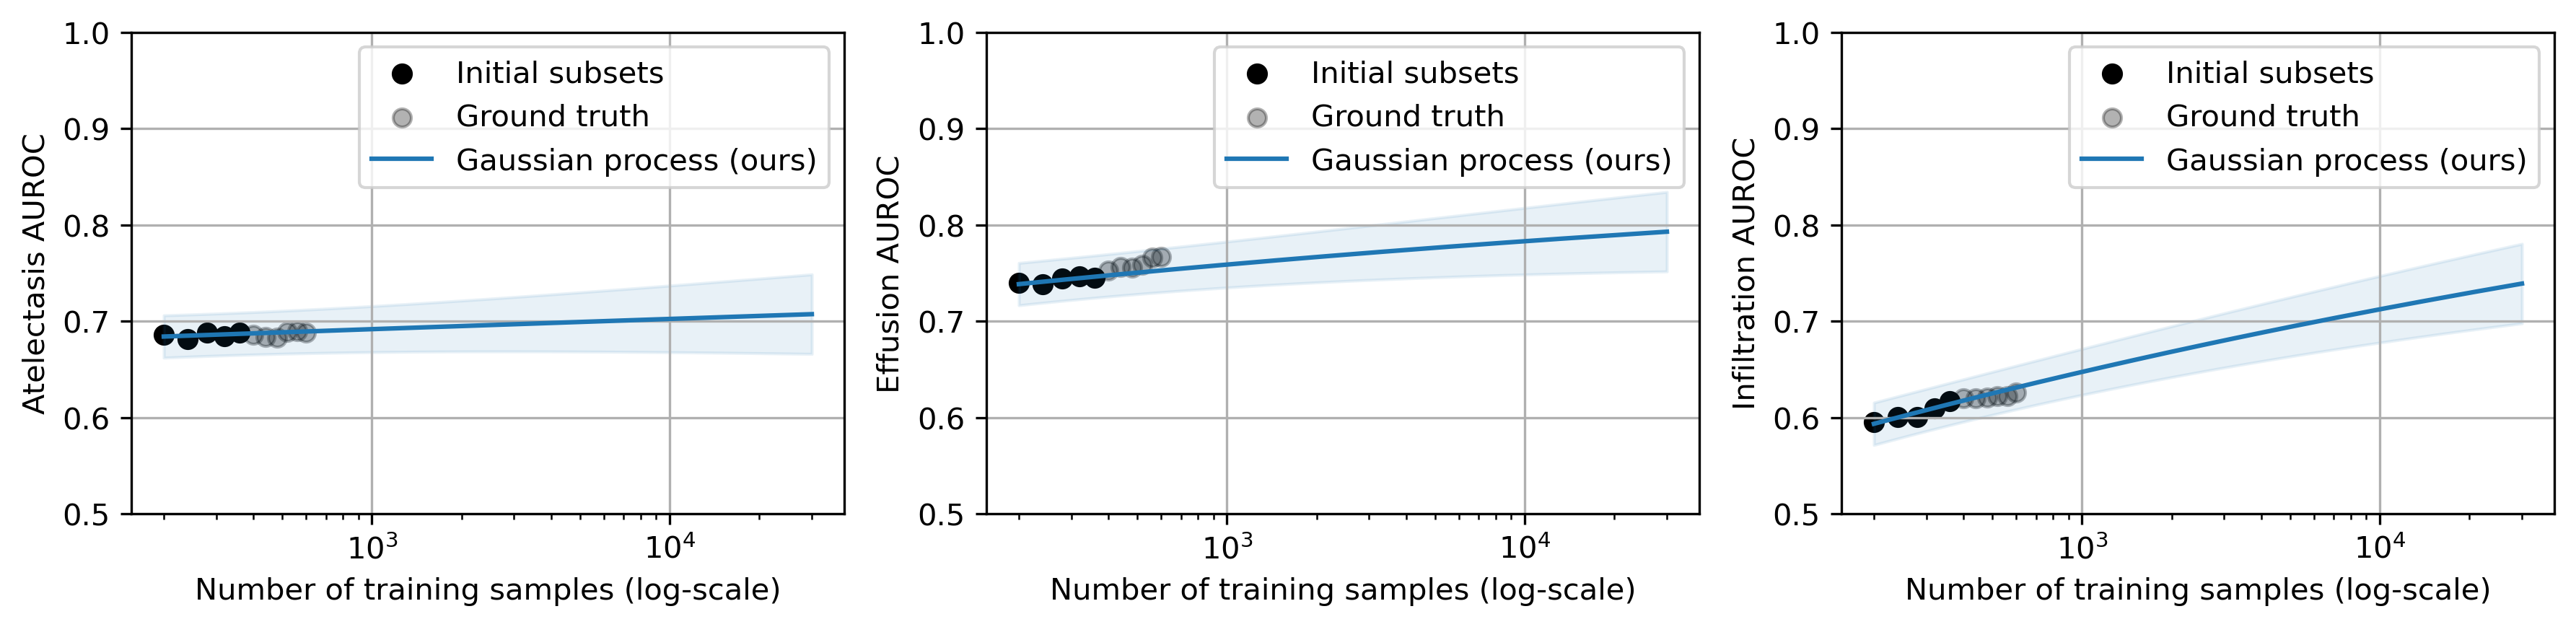

In [7]:
# ChestX-ray14 (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_short_range.csv')
plot_experiment(df, ['Atelectasis', 'Effusion', 'Infiltration'])

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5551], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.6636], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.9219], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-4.1430], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5189, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5897], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([0.1836], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.3080], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.2806], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5188, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 

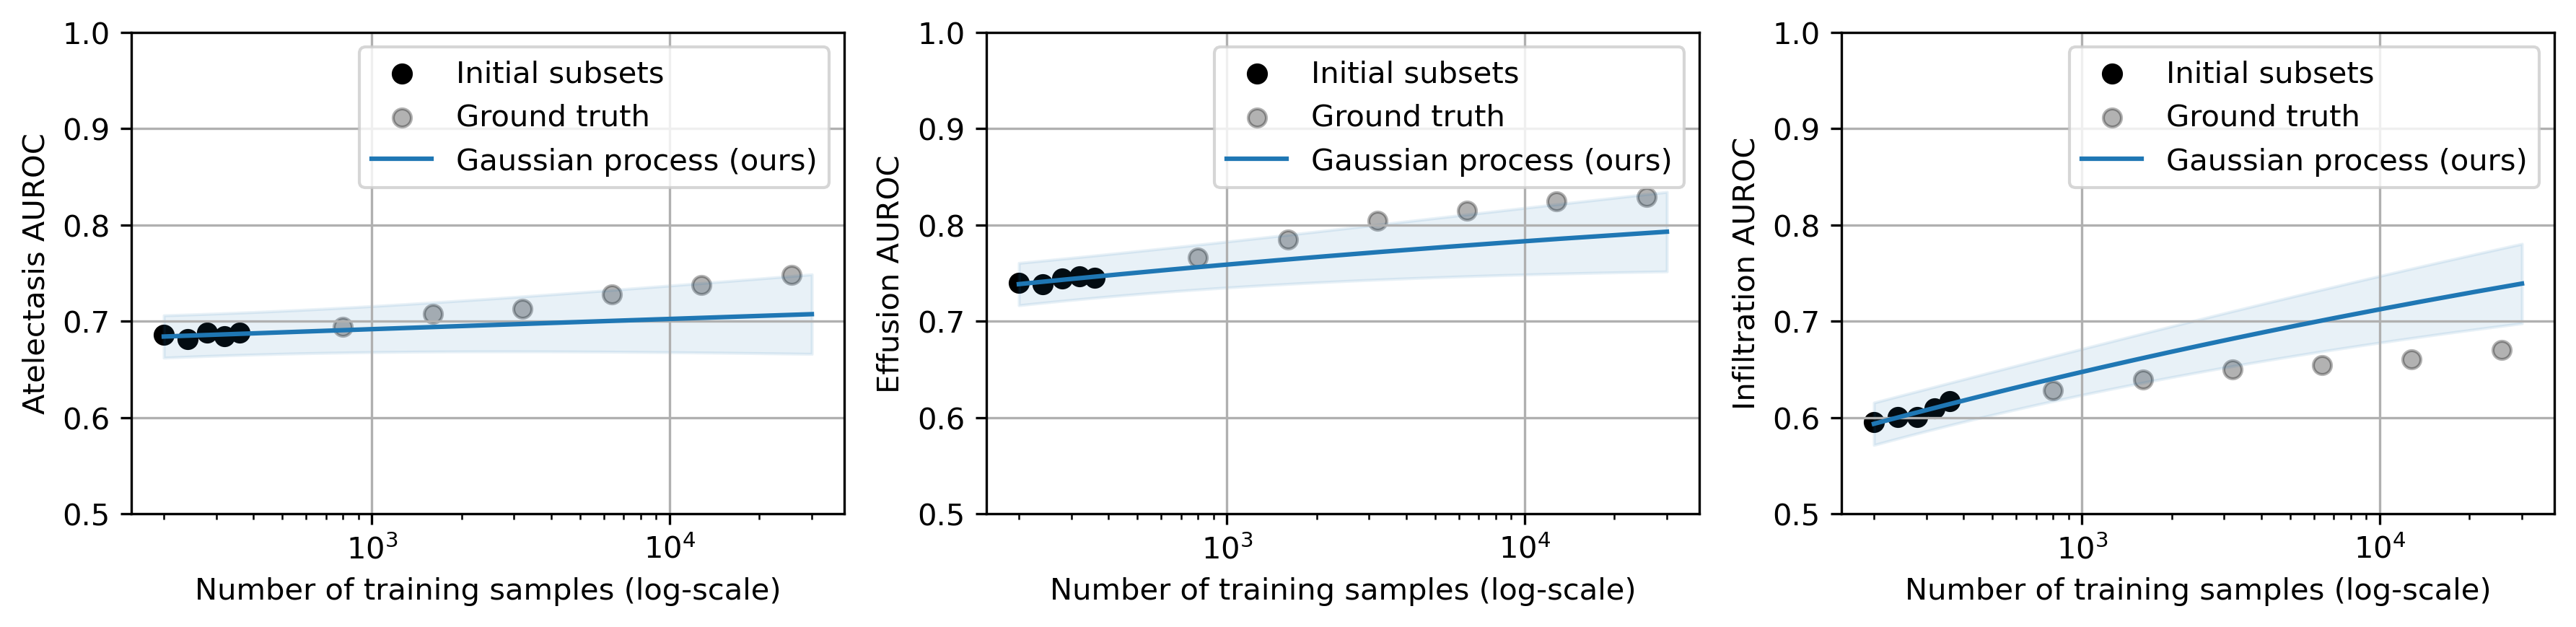

In [8]:
# ChestX-ray14 (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv')
plot_experiment(df, ['Atelectasis', 'Effusion', 'Infiltration'])

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.6151], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([-1.1122], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([0.8302], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([0.4450], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5190, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.6073], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.4531], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([0.4782], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-1.0386], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5193, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Pa

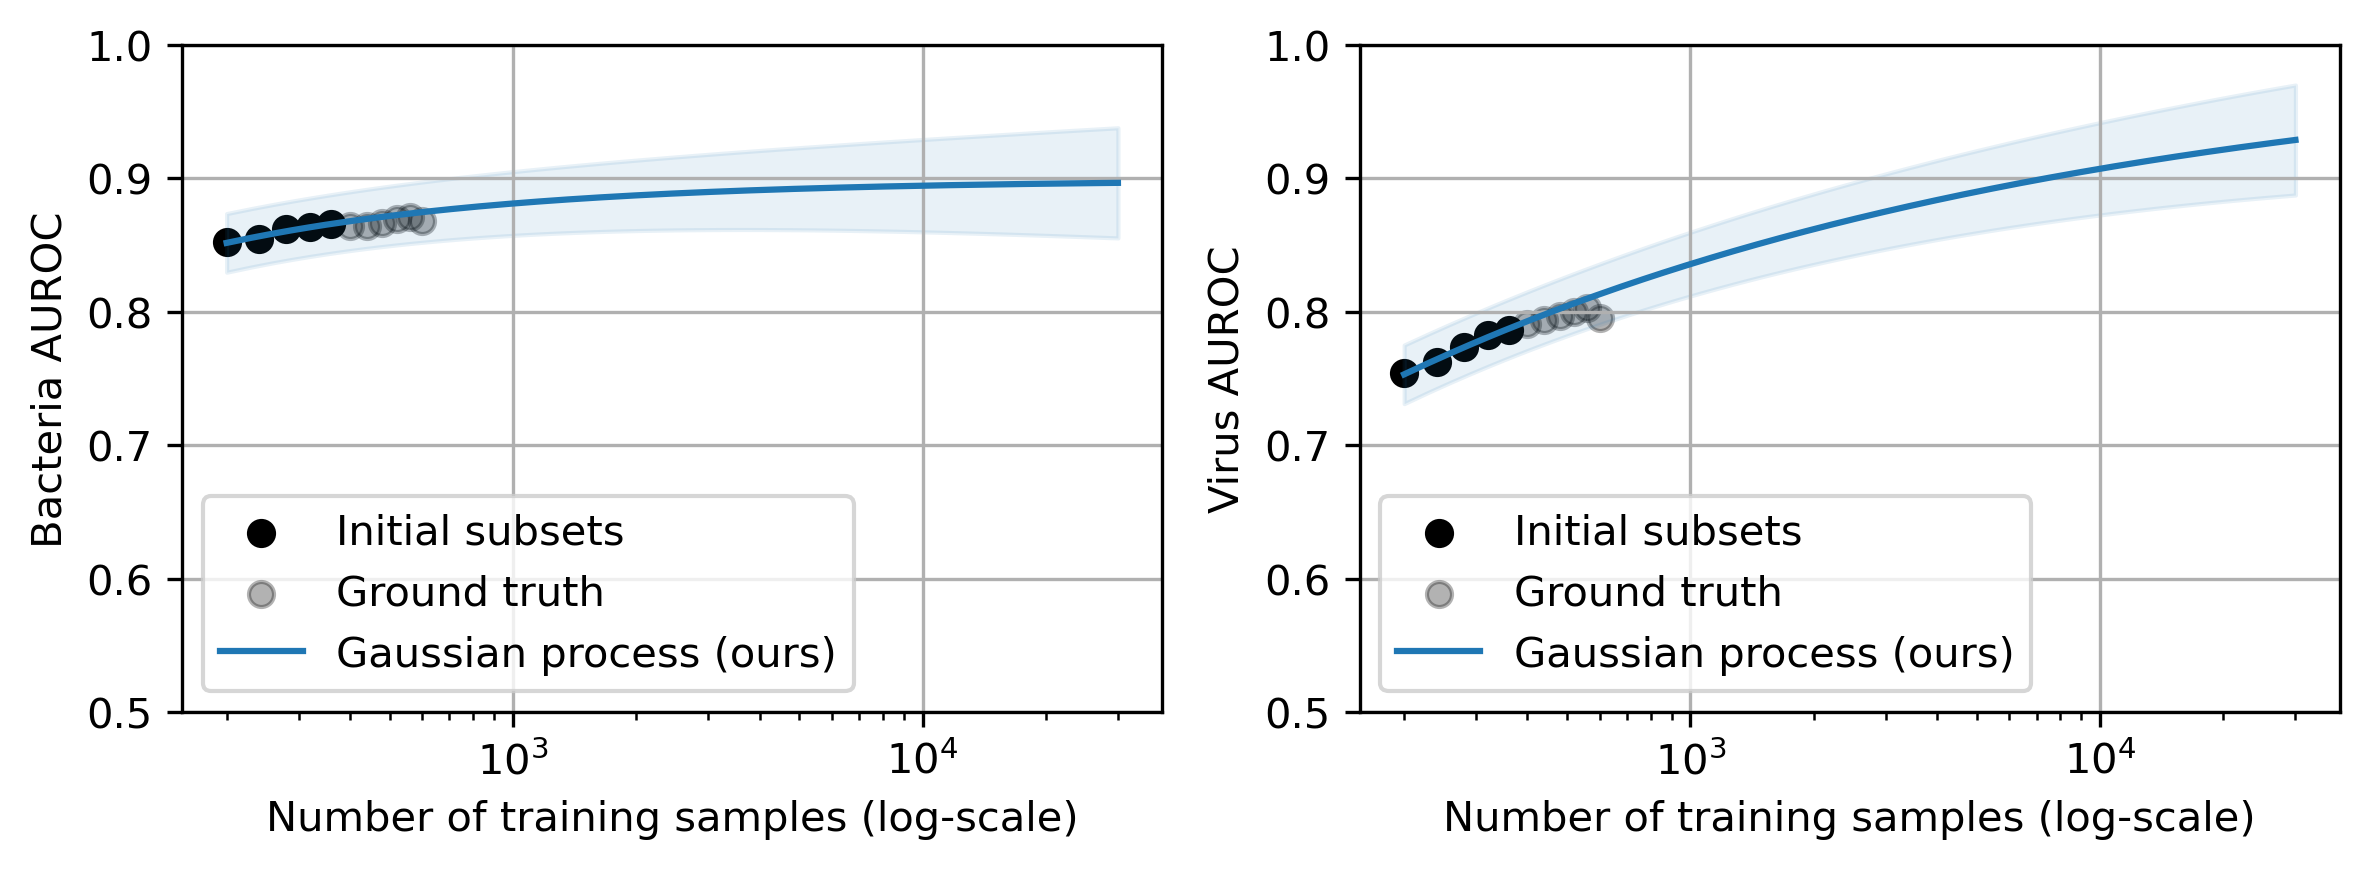

In [9]:
# Chest X-Ray (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_short_range.csv')
plot_experiment(df, ['Bacteria', 'Virus'])

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.6151], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([-1.1122], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([0.8302], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([0.4450], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5190, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.6073], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.4531], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([0.4782], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-1.0386], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5193, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Pa

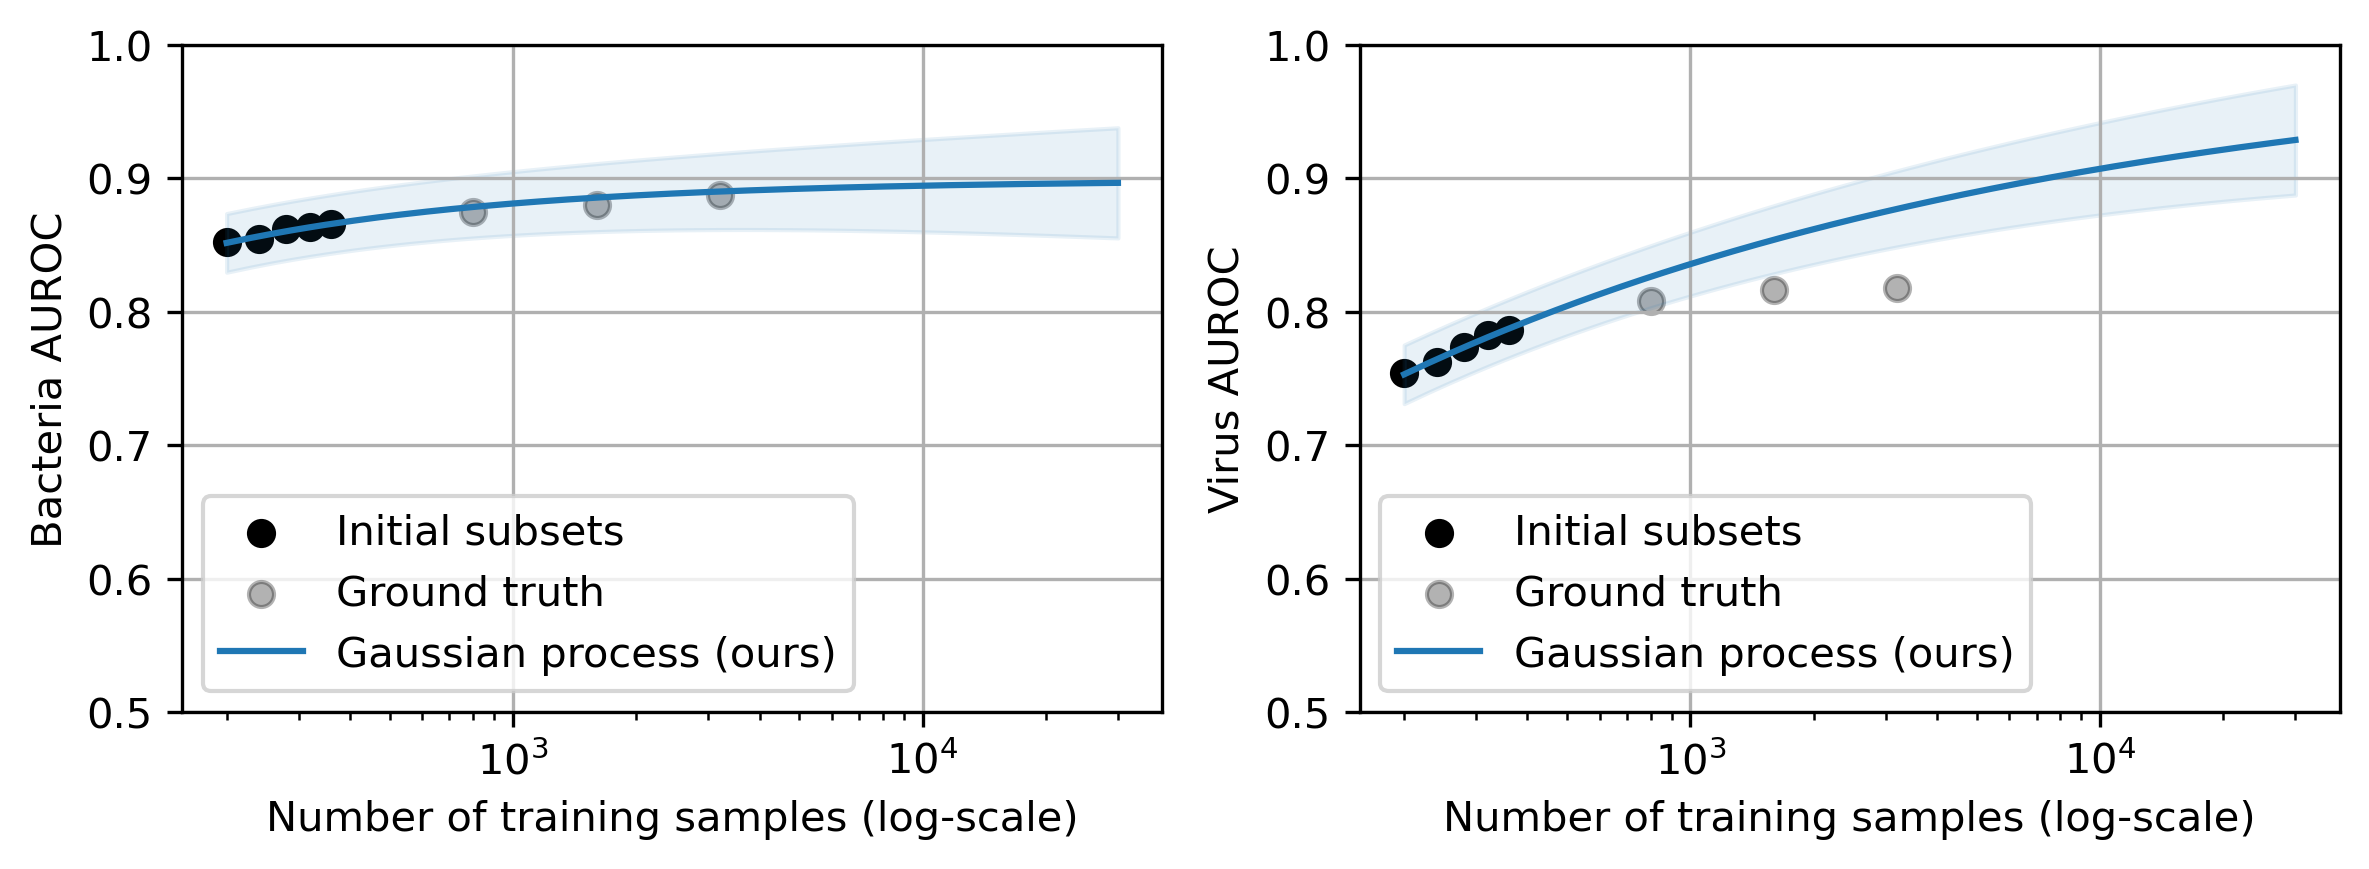

In [10]:
# Chest X-Ray (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_long_range.csv')
plot_experiment(df, ['Bacteria', 'Virus'])

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.3371], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([13.0723], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-2.0268], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.0918], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5183, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0147]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-11.7278], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([-10.4232], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([0.6813], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([9.1046], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5179, requires_grad=True)
covar_module.base_kernel.raw_lengthscale

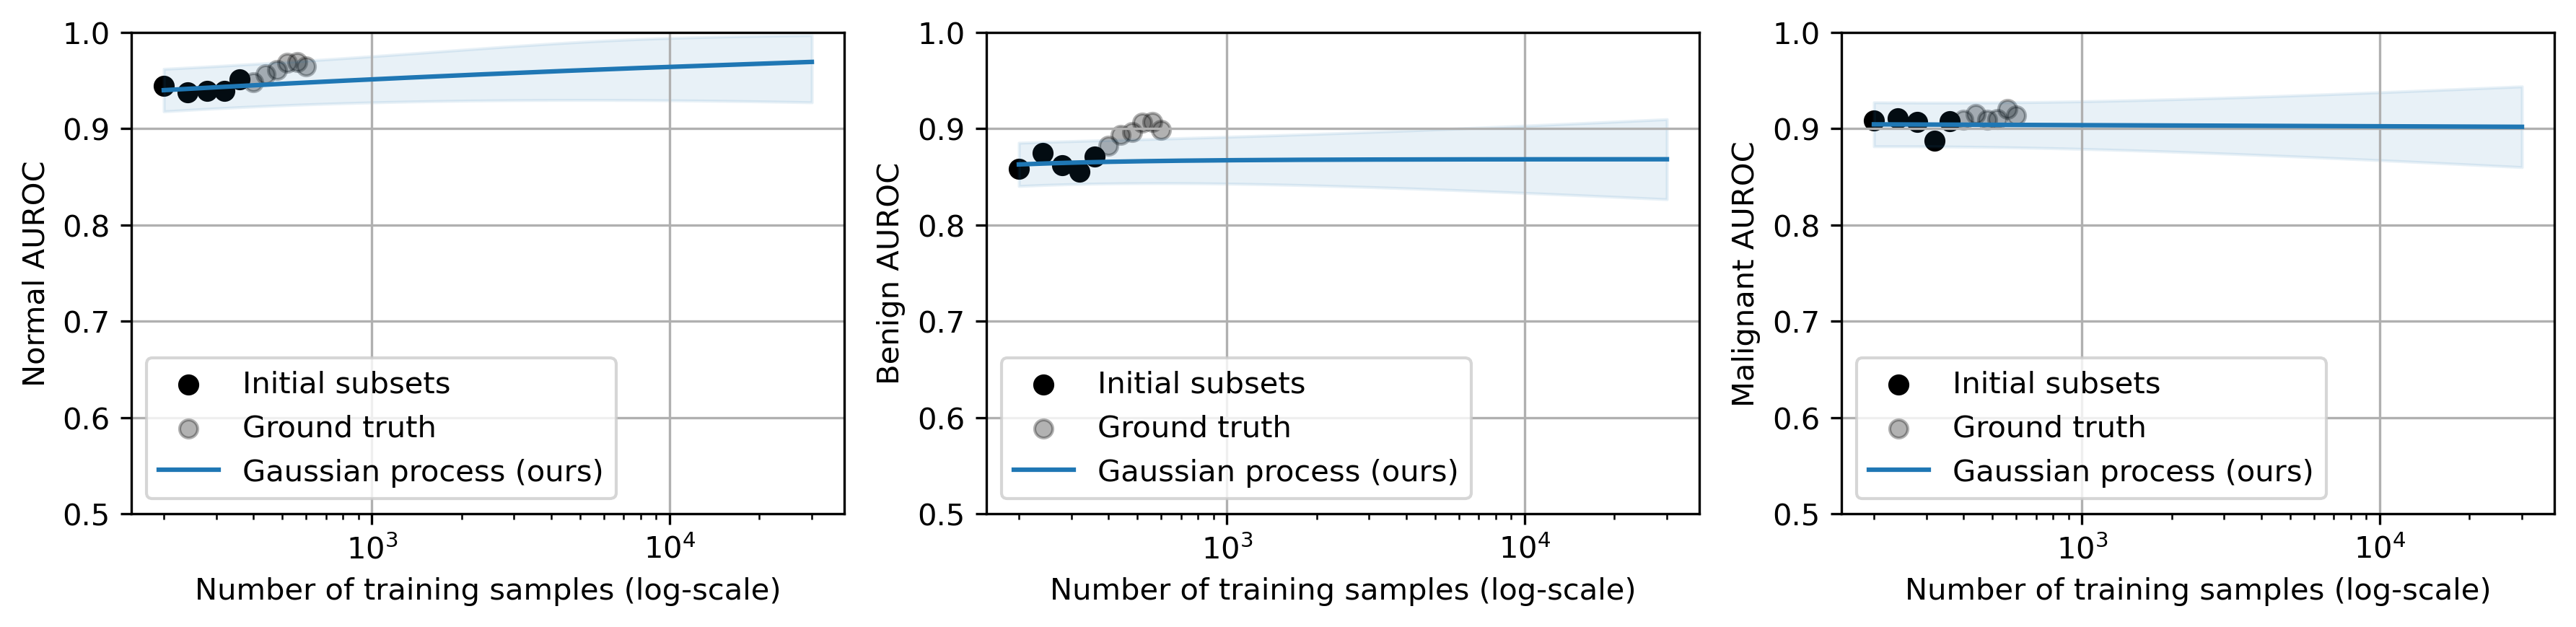

In [11]:
# BUSI (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/BUSI_short_range.csv')
plot_experiment(df, ['Normal', 'Benign', 'Malignant'])

In [12]:
import seaborn as sns
palette = sns.color_palette().as_hex()
fourth_color = palette[4]
print(fourth_color)

#9467bd


In [13]:
short_range_experiments = ['/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_short_range.csv',
                           '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_short_range.csv',
                           '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/BUSI_short_range.csv']
short_range_labels = [['Atelectasis', 'Effusion', 'Infiltration'],
                      ['Bacteria', 'Virus'],
                      ['Normal', 'Benign', 'Malignant']]

In [14]:
def mean_performance(df):
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    return df

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5551], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.6636], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.9219], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-4.1430], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5189, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5897], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([0.1836], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.3080], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.2806], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5188, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 

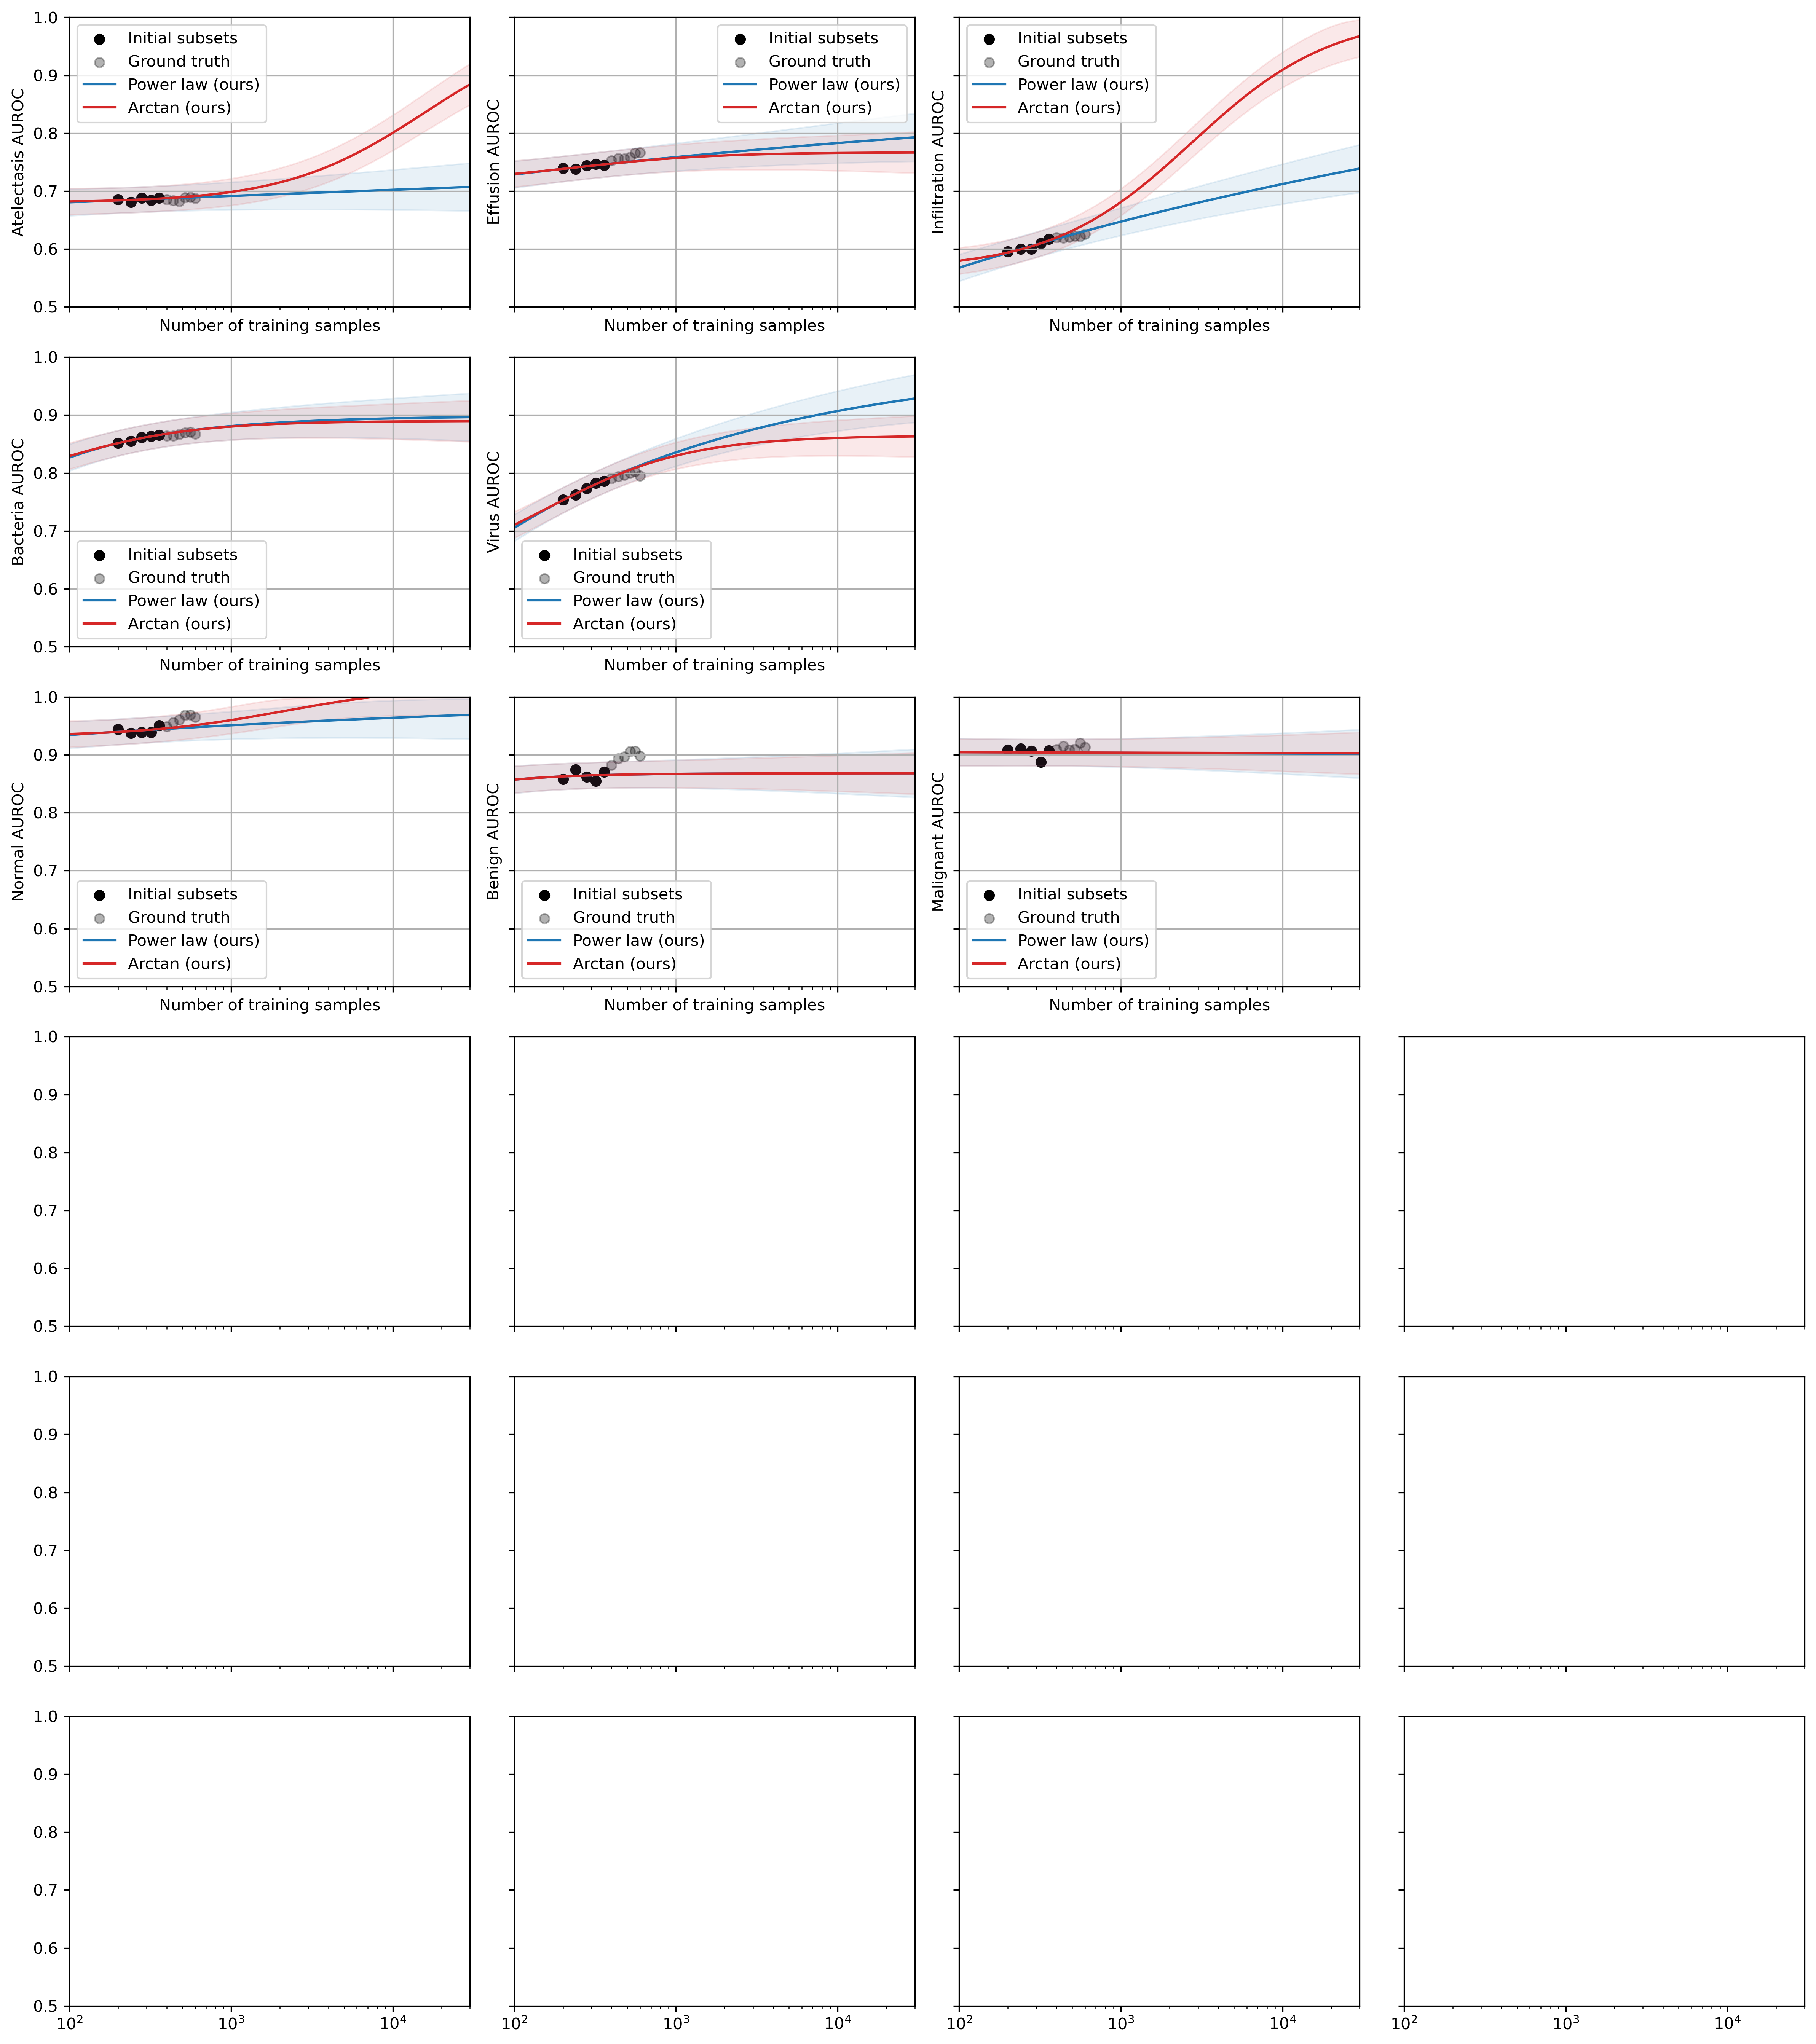

In [15]:
# Short range
ncols, nrows = 4, 6
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), sharex=True, sharey=True, dpi=300)
for dataset_index, (path, labels) in enumerate(zip(short_range_experiments, short_range_labels)):
    df = load_experiment(path)
    df = mean_performance(df)
    for label_index, _ in enumerate(labels):
        # Plot data
        figure_index = dataset_index*4+label_index
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train Gaussian process
        likelihood, model = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        lower, upper = truncated_normal_uncertainty(observed_pred.mean.numpy(), observed_pred.stddev.numpy())        
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Power law (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # Train Gaussian process
        likelihood, model = train_GPArctan(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        lower, upper = truncated_normal_uncertainty(observed_pred.mean.numpy(), observed_pred.stddev.numpy())        
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#d62728', label='Arctan (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#d62728', alpha=0.1)
        # Formatting
        np.array(axs).flatten()[figure_index]\
        .set_xlim([100, 30000])
        np.array(axs).flatten()[figure_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[figure_index]\
        .set_xscale('log')
        np.array(axs).flatten()[figure_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[figure_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[figure_index]\
        .legend()
        np.array(axs).flatten()[figure_index]\
        .grid()
    for index in range(len(labels),4):
        figure_index = dataset_index*4+index
        np.array(axs).flatten()[figure_index]\
        .imshow([[1]], cmap='gray', vmin=0, vmax=1)
        np.array(axs).flatten()[figure_index]\
        .set_axis_off()
fig.tight_layout()
plt.show()

In [16]:
long_range_experiments = ['/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv',
                          '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_long_range.csv']
long_range_labels = [['Atelectasis', 'Effusion', 'Infiltration'],
                     ['Bacteria', 'Virus']]

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5551], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([3.6636], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-0.9219], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-4.1430], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5189, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[50.0148]], requires_grad=True)
likelihood.noise_covar.raw_noise Parameter containing:
tensor([-12.5897], requires_grad=True)
mean_module.one_minus_epsilon Parameter containing:
tensor([0.1836], requires_grad=True)
mean_module.theta1 Parameter containing:
tensor([-1.3080], requires_grad=True)
mean_module.theta2 Parameter containing:
tensor([-2.2806], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-1.5188, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 

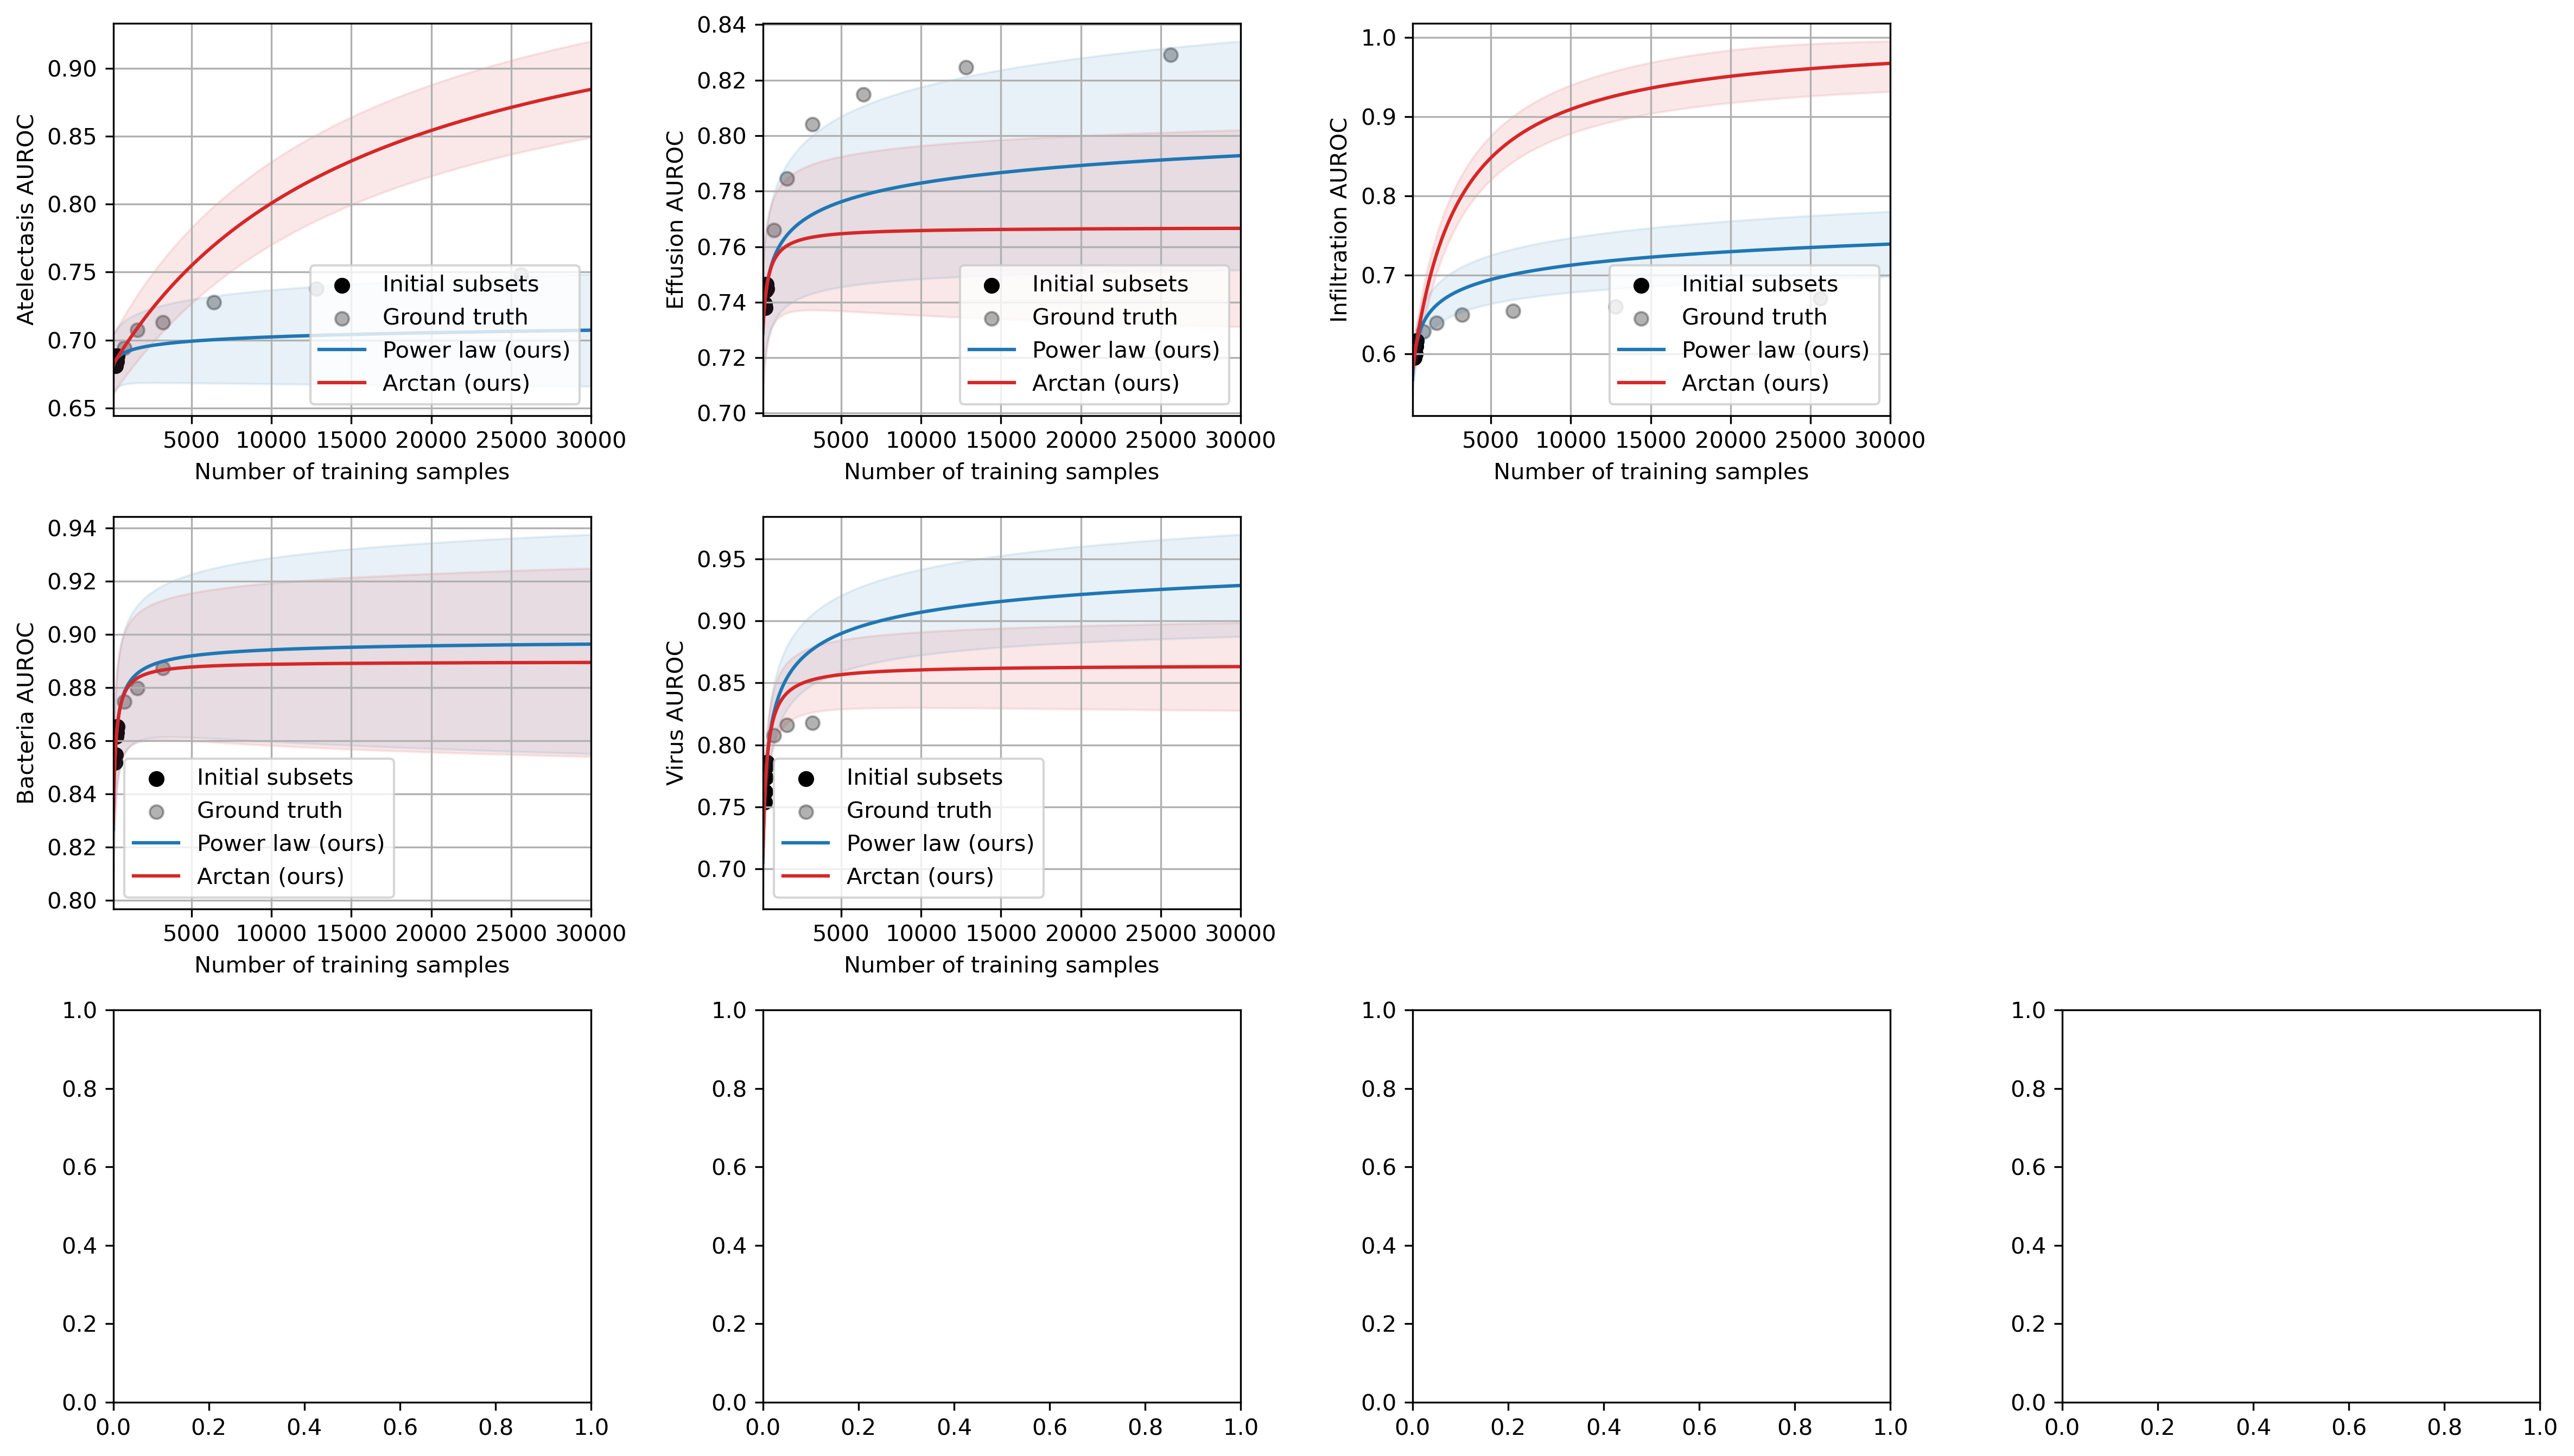

In [17]:
# Long range
ncols, nrows = 4, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
for dataset_index, (path, labels) in enumerate(zip(long_range_experiments, long_range_labels)):
    df = load_experiment(path)
    df = mean_performance(df)
    for label_index, _ in enumerate(labels):
        # Plot data
        figure_index = dataset_index*4+label_index
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[figure_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        # Train Gaussian process
        likelihood, model = train_GPPowerLaw(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        lower, upper = truncated_normal_uncertainty(observed_pred.mean.numpy(), observed_pred.stddev.numpy())        
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Power law (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        # Train Gaussian process
        likelihood, model = train_GPArctan(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        lower, upper = truncated_normal_uncertainty(observed_pred.mean.numpy(), observed_pred.stddev.numpy())        
        np.array(axs).flatten()[figure_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#d62728', label='Arctan (ours)')
        np.array(axs).flatten()[figure_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#d62728', alpha=0.1)
        # Formatting
        np.array(axs).flatten()[figure_index]\
        .set_xlim([100, 30000])
        #np.array(axs).flatten()[figure_index]\
        #.set_ylim([0.5, 1.0])
        #np.array(axs).flatten()[figure_index]\
        #.set_xscale('log')
        np.array(axs).flatten()[figure_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[figure_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[figure_index]\
        .legend()
        np.array(axs).flatten()[figure_index]\
        .grid()
        np.array(axs).flatten()[label_index]\
        .legend(loc='lower right')
    for index in range(len(labels),4):
        figure_index = dataset_index*4+index
        np.array(axs).flatten()[figure_index]\
        .imshow([[1]], cmap='gray', vmin=0, vmax=1)
        np.array(axs).flatten()[figure_index]\
        .set_axis_off()
fig.tight_layout()
plt.show()